# Assignment: Linear Models
## Do two questions in total: "Q1+Q2" or "Q1+Q3"
### `! git clone https://github.com/ds3001f25/linear_models_assignment.git`

**Q1.** Let's explore multiple linear regression in a two-variable case, to build more intuition about what is happening.

Suppose the model is
$$
\hat{y}_i = b_0 + b_1 z_{i1} + b_2 z_{i2}
$$
Assume that $z_{ij}$ is centered or de-meaned, so that $z_{ij} = x_{ij} - m_j$ where $m_j$ is the mean of variable $j$ and $x_{ij}$ is the original value of variable $j$ for observation $i$. Notice that this implies
$$
\dfrac{1}{N} \sum_{i=1}^N z_{ij} = 0
$$
which will simplify your calculations below substantially!

1. Write down the SSE for this model.
2. Take partial derivatives with respect to $b_0$, $b_1$, and $b_2$.
3. Verify that the average error is zero and $e \cdot z =0$ at the optimum, just as in the single linear regression case.
4. Show that the optimal intercept is $b_0^* = \bar{y}$. Eliminate $b_0^*$ from the remaining equations, and focus on $b_1$ and $b_2$.
5. Write your results as a matrix equation in the form "$Ab=C$". These are called the **normal equations**.
6. Divide both sides by $N$ and substitute $z_{ij} = x_{ij} - m_j$ back into your normal equations for $x_{ij}$. What is the matrix $A$? What is the vector $C$? Explain the intuition of your discovery.

Solutions uploaded

**Q2.** This question is a case study for linear models. The data are about car prices. In particular, they include:

  - `Price`, `Color`, `Seating_Capacity`
  - `Body_Type`: crossover, hatchback, muv, sedan, suv
  - `Make`, `Make_Year`: The brand of car and year produced
  - `Mileage_Run`: The number of miles on the odometer
  - `Fuel_Type`: Diesel or gasoline/petrol
  - `Transmission`, `Transmission_Type`:  speeds and automatic/manual

  1. Load `cars_hw.csv`. These data were really dirty, and I've already cleaned them a significant amount in terms of missing values and other issues, but some issues remain (e.g. outliers, badly scaled variables that require a log or arcsinh transformation). Clean the data however you think is most appropriate.
  2. Summarize the `Price` variable and create a kernel density plot. Use `.groupby()` and `.describe()` to summarize prices by brand (`Make`). Make a grouped kernel density plot by `Make`. Which car brands are the most expensive? What do prices look like in general?
  3. Split the data into an 80% training set and a 20% testing set.
  4. Make a model where you regress price on the numeric variables alone; what is the $R^2$ and `RMSE` on the training set and test set? Make a second model where, for the categorical variables, you regress price on a model comprised of one-hot encoded regressors/features alone (you can use `pd.get_dummies()`; be careful of the dummy variable trap); what is the $R^2$ and `RMSE` on the test set? Which model performs better on the test set? Make a third model that combines all the regressors from the previous two; what is the $R^2$ and `RMSE` on the test set? Does the joint model perform better or worse, and by home much?
  5. Use the `PolynomialFeatures` function from `sklearn` to expand the set of numerical variables you're using in the regression. As you increase the degree of the expansion, how do the $R^2$ and `RMSE` change? At what point does $R^2$ go negative on the test set? For your best model with expanded features, what is the $R^2$ and `RMSE`? How does it compare to your best model from part 4?
  6. For your best model so far, determine the predicted values for the test data and plot them against the true values. Do the predicted values and true values roughly line up along the diagonal, or not? Compute the residuals/errors for the test data and create a kernel density plot. Do the residuals look roughly bell-shaped around zero? Evaluate the strengths and weaknesses of your model.

**Q3.** This question refers to the `heart_hw.csv` data. It contains three variables:

  - `y`: Whether the individual survived for three years, coded 0 for death and 1 for survival
  - `age`: Patient's age
  - `transplant`: `control` for not receiving a transplant and `treatment` for receiving a transplant

Since a heart transplant is a dangerous operation and even people who successfully get heart transplants might suffer later complications, we want to look at whether a group of transplant recipients tends to survive longer than a comparison group who does not get the procedure.

1. Compute (a) the proportion of people who survive in the control group who do not receive a transplant, and (b) the difference between the proportion of people who survive in the treatment group and the proportion of people who survive in the control group. In a randomized controlled trial, this is called the **average treatment effect**.
2. Regress `y` on `transplant` using a linear model with a constant. How does the constant/intercept of the regression and the coefficient on transplant compare to your answers from part 1? Explain the relationship clearly.
3. We'd like to include `age` in the regression, since it's reasonable to expect that older patients are less likely to survive an extensive surgery like a heart transplant. Regress `y` on a constant, transplant, and age. How does the intercept change?
4. Build a more flexible model that allows for non-linear age effects and interactions between age and treatment. Use a train-test split to validate your model. Estimate your best model, predict the survival probability by age, and plot your results conditional on receiving a transplant and not. Describe what you see.
5. Imagine someone suggests using these kinds of models to select who receives organ transplants; perhaps the CDC or NIH starts using a scoring algorithm to decide who is contacted about a potential organ. What are your concerns about how it is built and how it is deployed?

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import roc_auc_score, accuracy_score, brier_score_loss

# Load data
df = pd.read_csv("/content/heart_hw.csv")
df.columns = [c.strip().lower() for c in df.columns]

# Make treatment indicator: 1 = treatment, 0 = control
df["treat"] = (df["transplant"].astype(str).str.strip().str.lower() == "treatment").astype(int)

df.head()

,unnamed: 0,age,transplant,y,treat
0,1,53,control,0,0
1,2,43,control,0,0
2,3,52,control,0,0
3,4,52,control,0,0
4,5,54,control,0,0


In [42]:
# Q3.1
# (a) Proportion surviving in control and treatment
p_control = df.loc[df["treat"] == 0, "y"].mean()
p_treat   = df.loc[df["treat"] == 1, "y"].mean()

# (b) Difference (treatment - control)
ate = p_treat - p_control

print(f"Control survival:   {p_control:.4f}")
print(f"Treatment survival: {p_treat:.4f}")
print(f"Difference (ATE):   {ate:.4f}")

Control survival:   0.1176
Treatment survival: 0.3478
Difference (ATE):   0.2302


(a) The proportion of people who survived in the control group is 11.76%.

(b) The proportion of people who survived in the treatment group is 34.78%. The difference between these proportions (the average treatment effect) is 23.02%. It indicates that receiving a transplant is associated with about 23.02% higher survival rate compared to not receiving one.

y ~ 1 + treat (OLS)
Intercept (≈ P[y=1|control]):            0.1176
Coef on treat (≈ P[treat]-P[control]):    0.2302


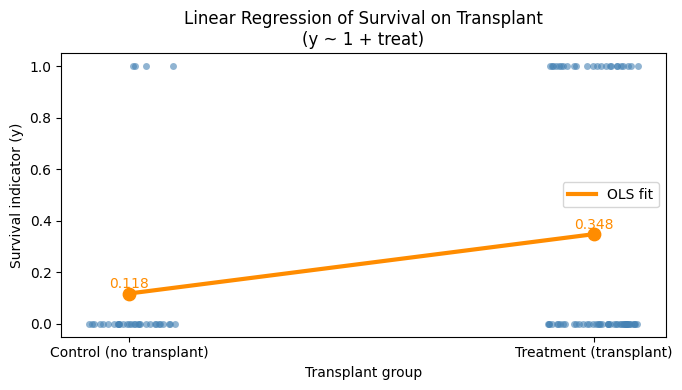

In [43]:
# Q3.2
# Fit regression model: y ~ 1 + treat
import seaborn as sns
X = df[["treat"]].values
y = df["y"].values
ols = LinearRegression().fit(X, y)

print("y ~ 1 + treat (OLS)")
print(f"Intercept (≈ P[y=1|control]):            {ols.intercept_:.4f}")
print(f"Coef on treat (≈ P[treat]-P[control]):    {ols.coef_[0]:.4f}")

# Predicted values for control (0) and treatment (1)
preds = ols.predict(np.array([[0], [1]]))

# Create the plot
plt.figure(figsize=(7, 4))
sns.stripplot(x="treat", y="y", data=df, jitter=0.1, alpha=0.6, color="steelblue")
plt.plot([0, 1], preds, color="darkorange", linewidth=3, label="OLS fit")

# Annotate the points
plt.scatter([0, 1], preds, color="darkorange", s=80, zorder=5)
plt.text(0, preds[0] + 0.02, f"{preds[0]:.3f}", ha="center", fontsize=10, color="darkorange")
plt.text(1, preds[1] + 0.02, f"{preds[1]:.3f}", ha="center", fontsize=10, color="darkorange")

# Customize labels
plt.xticks([0, 1], ["Control (no transplant)", "Treatment (transplant)"])
plt.xlabel("Transplant group")
plt.ylabel("Survival indicator (y)")
plt.title("Linear Regression of Survival on Transplant\n(y ~ 1 + treat)")
plt.legend()
plt.tight_layout()
plt.show()

The regression results match the findings from part 1. The intercept (0.1176) represents the average survival rate in the control group, the same as before. The coefficient on transplant (0.2302) equals the difference between treatment and control survival rates, showing that receiving a transplant increases survival probability by about 23.02%.

y ~ 1 + treat + age (OLS)
(uncentered) Intercept: 0.7020, β_treat: 0.2647, β_age: -0.0136
( centered ) Intercept: 0.0945  [age centered at 44.64]
( centered ) β_treat:   0.2647, β_age_c: -0.0136


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


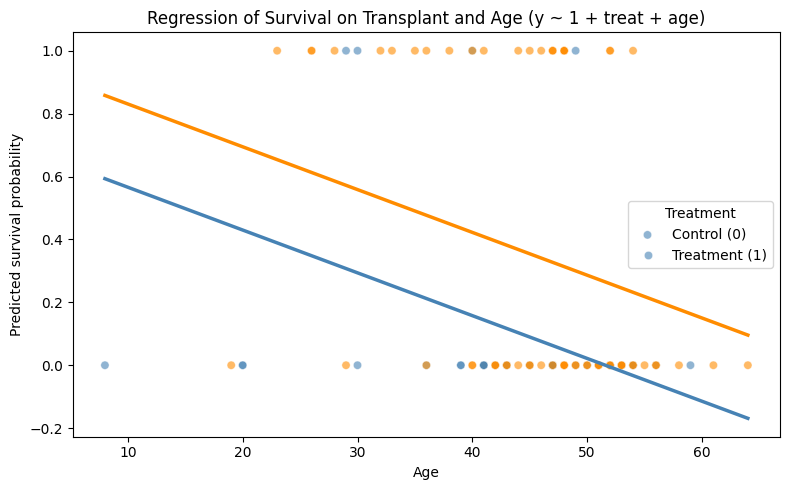

In [30]:
# Q3.3
# Uncentered age
X3 = df[["treat", "age"]].values
y  = df["y"].values
ols3 = LinearRegression().fit(X3, y)

# Center age to make intercept interpretable (mean-age control)
age_mean = df["age"].mean()
df["age_c"] = df["age"] - age_mean
X3c = df[["treat", "age_c"]].values
ols3c = LinearRegression().fit(X3c, y)

print("y ~ 1 + treat + age (OLS)")
print(f"(uncentered) Intercept: {ols3.intercept_:.4f}, β_treat: {ols3.coef_[0]:.4f}, β_age: {ols3.coef_[1]:.4f}")
print(f"( centered ) Intercept: {ols3c.intercept_:.4f}  [age centered at {age_mean:.2f}]")
print(f"( centered ) β_treat:   {ols3c.coef_[0]:.4f}, β_age_c: {ols3c.coef_[1]:.4f}")

# Predict survival across age for both treatment groups
age_range = np.linspace(df["age"].min(), df["age"].max(), 100)
pred_df = pd.DataFrame({
    "age": np.tile(age_range, 2),
    "treat": np.repeat([0, 1], repeats=len(age_range))
})
pred_df["pred"] = ols3.predict(pred_df[["treat", "age"]])

# Plot
plt.figure(figsize=(8, 5))
sns.scatterplot(x="age", y="y", hue="treat", data=df, palette=["steelblue", "darkorange"], alpha=0.6)
sns.lineplot(x="age", y="pred", hue="treat", data=pred_df, palette=["steelblue", "darkorange"], linewidth=2.5)
plt.xlabel("Age")
plt.ylabel("Predicted survival probability")
plt.title("Regression of Survival on Transplant and Age (y ~ 1 + treat + age)")
plt.legend(title="Treatment", labels=["Control (0)", "Treatment (1)"])
plt.tight_layout()
plt.show()

After including age in the regression, the intercept decreases from about 0.7020 (uncentered) to 0.0945 when age is centered at its mean of 44.64. It means that the intercept now represents the predicted survival probability for a control-group patient of average age. As age increases, survival probability decreases (β_age ≈ –0.0136), so adjusting for age lowers the baseline survival estimate to a more realistic average level.

[Regular] Best degree=1, CV acc=0.738, Test acc=0.774


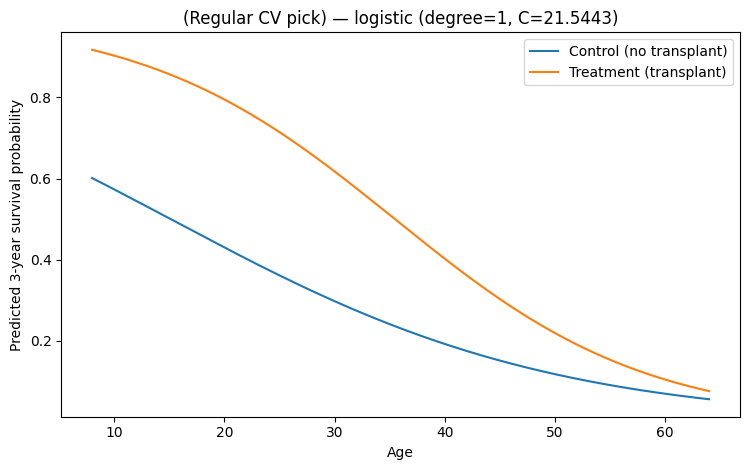

[Curvature-required] Best degree=2, CV acc=0.722, Test acc=0.742


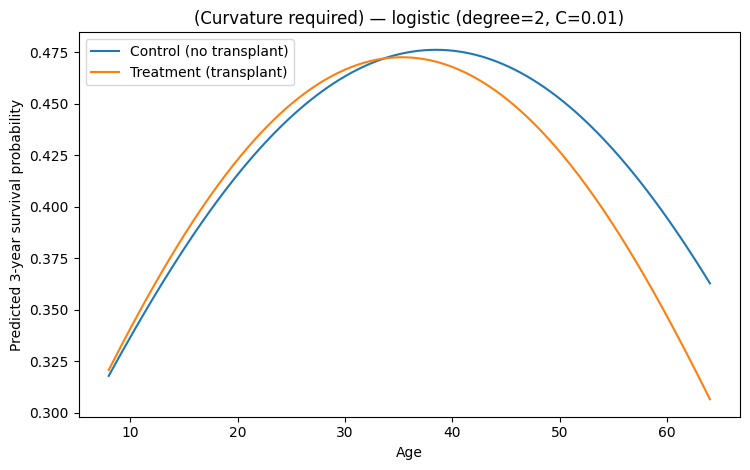

In [40]:
# Q3.4
# splits
df_tv, df_te, y_tv, y_te = train_test_split(df, y, test_size=0.30, random_state=42, stratify=y)
df_tr, df_va, y_tr, y_va = train_test_split(df_tv, y_tv, test_size=0.25, random_state=42, stratify=y_tv)

# center/scale from train only
age_mean_tr = df_tr["age"].mean()
age_std_tr  = df_tr["age"].std(ddof=0)

def make_features(frame, degree, age_mean=age_mean_tr, age_std=age_std_tr):
    """Polynomial in standardized age + treat + all interactions."""
    z = ((frame[["age"]].values - age_mean) / (age_std if age_std > 0 else 1.0))   # (n,1)
    treat = frame[["treat"]].values.astype(float)                                   # (n,1)
    poly = np.hstack([z**k for k in range(1, degree + 1)])                          # (n,d)
    inter = treat * poly                                                            # (n,d)
    X = np.hstack([poly, treat, inter])                                             # (n, 2d+1)
    return X

def fit_with_cv(min_degree=1, max_degree=4, C_grid=None, solver="liblinear", random_state=42):
    if C_grid is None:
        C_grid = np.logspace(-2, 2, 7)  # 0.01 ... 100

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
    best = {"degree": None, "C": None, "cv_acc": -np.inf}

    # grid-search on TRAIN ONLY
    for d in range(min_degree, max_degree + 1):
        X_tr = make_features(df_tr, d)
        for C in C_grid:
            clf = LogisticRegression(max_iter=5000, solver=solver, C=C)
            cv_scores = cross_val_score(clf, X_tr, y_tr, cv=skf, scoring="accuracy")
            m = cv_scores.mean()
            if m > best["cv_acc"]:
                best.update({"degree": d, "C": C, "cv_acc": m})

    # refit on TRAIN+VAL with the winner; evaluate on TEST
    X_tv = make_features(df_tv, degree=best["degree"])
    X_te = make_features(df_te, degree=best["degree"])
    final_clf = LogisticRegression(max_iter=5000, solver=solver, C=best["C"]).fit(X_tv, y_tv)
    test_acc = (final_clf.predict(X_te) == y_te).mean()
    return best["degree"], best["C"], best["cv_acc"], test_acc, final_clf

def plot_curves(model, degree, C_used, title_prefix="Predicted survival vs age"):
    age_grid = np.linspace(df["age"].min(), df["age"].max(), 300)
    grid = pd.DataFrame({"age": np.tile(age_grid, 2),
                         "treat": np.repeat([0, 1], len(age_grid))})
    Xg = make_features(grid, degree)
    grid["pred"] = model.predict_proba(Xg)[:, 1]

    m0 = grid["treat"].values == 0
    m1 = ~m0
    plt.figure(figsize=(7.6, 4.8))
    plt.plot(age_grid, grid.loc[m0, "pred"], label="Control (no transplant)")
    plt.plot(age_grid, grid.loc[m1, "pred"], label="Treatment (transplant)")
    plt.xlabel("Age"); plt.ylabel("Predicted 3-year survival probability")
    plt.title(f"{title_prefix} — logistic (degree={degree}, C={C_used:g})")
    plt.legend(); plt.tight_layout(); plt.show()

# run both variants
deg_cv, C_cv, cv_acc, test_acc, clf_cv = fit_with_cv(min_degree=1, max_degree=4)
print(f"[Regular] Best degree={deg_cv}, CV acc={cv_acc:.3f}, Test acc={test_acc:.3f}")
plot_curves(clf_cv, degree=deg_cv, C_used=C_cv, title_prefix="(Regular CV pick)")

deg_curv, C_curv, cv_acc2, test_acc2, clf_curv = fit_with_cv(min_degree=2, max_degree=4)
print(f"[Curvature-required] Best degree={deg_curv}, CV acc={cv_acc2:.3f}, Test acc={test_acc2:.3f}")
plot_curves(clf_curv, degree=deg_curv, C_used=C_curv, title_prefix="(Curvature required)")

Using logistic regression with polynomial age and all age×treatment interactions, CV on the training set selected degree=1 (test accuracy ≈0.77). Predicted survival decreases with age for both groups; transplant patients have higher survival at nearly all ages, but the gap narrows with age and the curves converge in the 50s–60s.

Forcing curvature (degree=2) produced slight bending near ages 30–35 but did not improve test performance (≈0.74).

In [ ]:
# Q3.5

Historical data embed selection bias like who was evaluated, listed, and social factors. A model trained on that history can entrench disparities by age, race, income, or geography. Shift in practice patterns over time also risks dataset shift and miscalibration.


Deployment must be transparent and auditable. Document features, missing-data handling, fairness checks (group calibration/error rates), uncertainty, and model monitoring. The system should support clinicians, not replace them. Otherwise we swap bedside ethics for opaque automation.